## Step 1: Imports and Setup

In [1]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

from src import prepare_datasets, ModelTrainer, accuracy, precision, recall, f1_score

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'
download_data = True
normalize_data = True

## Step 2: Data Preparation


In [2]:
# prepare datasets
trainset, valset = prepare_datasets(dataset_name, data_root, 
                                    normalize=normalize_data, 
                                    precalculated_stats=(0.4733640253543854, 0.21108488738536835))

using precalculated stats - mean: 0.4733640253543854, std: 0.21108488738536835
Files already downloaded and verified
Files already downloaded and verified
after normalization: mean: -4.796001576323761e-06, std: 1.000001072883606


## Step 3: Define CNN Architectures

### Model 1: Simple CNN


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input: 3x32x32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # output: 32x32x32
        self.relu1 = nn.ReLU()
        # output size: 32x32x32
        self.pool1 = nn.MaxPool2d(2, 2)
        # output size: 32x16x16

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # output: 64x16x16
        self.relu2 = nn.ReLU()
        # output size: 64x16x16
        self.pool2 = nn.MaxPool2d(2, 2)
        # output size: 64x8x8

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # conv1
        x = self.conv1(x)  # input: [batch, 3, 32,32], output: [batch,32,32,32]
        x = self.relu1(x)  # [batch,32,32,32]
        x = self.pool1(x)  # [batch,32,16,16]
        
        # conv2
        x = self.conv2(x)  # [batch,64,16,16]
        x = self.relu2(x)  # [batch,64,16,16]
        x = self.pool2(x)  # [batch,64,8,8]
        
        x = x.view(x.size(0), -1)  # [batch, 64*8*8]
        x = self.fc1(x)  # [batch,128]
        x = self.relu3(x)  # [batch,128]
        x = self.fc2(x)  # [batch,10]
        
        return x

In [4]:
class SuperSimpleNN(nn.Module):

    def __init__(self, input_size: int, num_classes: int):
        super().__init__()
        self.fc1 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        return x

## Step 4: Initialize and Train Models

### Training Function

In [5]:
def train_model(model, model_name, num_epochs=25):
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        run_karpathy_checks=True,
        # wandb_project="cifar10",
        # wandb_entity="futuregoose",
        # sweep=False,
        seed=42,
        # strict_reproducibility=True
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

### Train Model 1: Simple CNN

In [6]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Random seed set to 42 for reproducibility.

🚀 Running Karpathy's Verification Tests
These tests help verify the training setup and catch common issues early.


🔍 Checking Initial Loss
Initial loss should be close to -log(1/n_classes) for random predictions.
This verifies proper weight initialization.

Initial loss: 2.3088
Expected loss for random predictions: 2.3026
✅ Initial loss matches expected value

🎯 Testing Input Dependence
Model should perform better on real data than zero input.
This verifies the model actually uses input information.

Normal input loss: 2.3062
Zero input loss: 2.3011
❌ Loss difference is negative: -0.0051
Model performs worse on real data than zero input!
Suggestions:
1. Check weight initialization
2. Verify input normalization
3. Ensure model architecture is correct

👁️ Visualizing Network Input
Showing data exactly as it enters the model. Verify:
1. Images are properly normalized/preprocessed
2. Labels match the images
3. No unintended transformations

Data

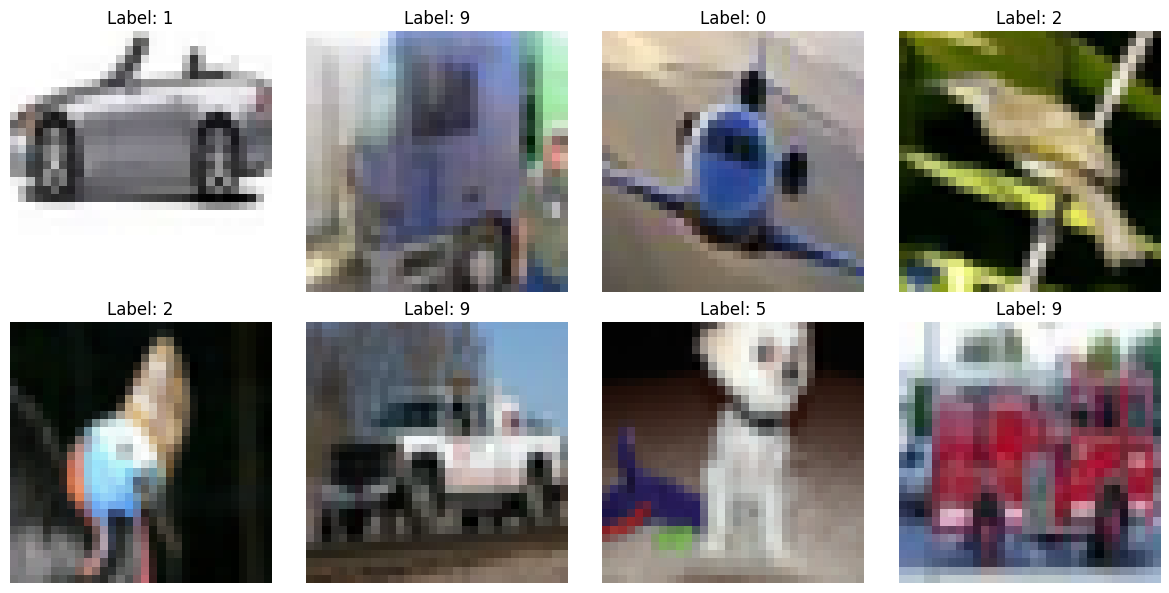


🎯 Testing Model Capacity
Attempting to overfit a single batch. Success indicates the model has sufficient capacity.
Target loss: 0.0100
Loss should decrease rapidly and reach near-zero.

Iteration 0: Loss = 2.304836
✅ Target loss reached at iteration 35

✅ Verification Tests Completed
Review the results above to ensure your training setup is solid.

Karpathy verification tests completed.
[epoch 01] train loss: 1.5121 | val loss: 1.1979 | accuracy: 57.80%
Validation loss decreased (inf --> 1.1979). Saving model.
[epoch 02] train loss: 1.0952 | val loss: 1.0121 | accuracy: 64.65%
Validation loss decreased (1.1979 --> 1.0121). Saving model.
[epoch 03] train loss: 0.9438 | val loss: 0.9755 | accuracy: 65.83%
Validation loss decreased (1.0121 --> 0.9755). Saving model.
[epoch 04] train loss: 0.8259 | val loss: 0.8701 | accuracy: 69.76%
Validation loss decreased (0.9755 --> 0.8701). Saving model.
[epoch 05] train loss: 0.7380 | val loss: 0.9070 | accuracy: 68.30%
EarlyStopping counter: 1 ou

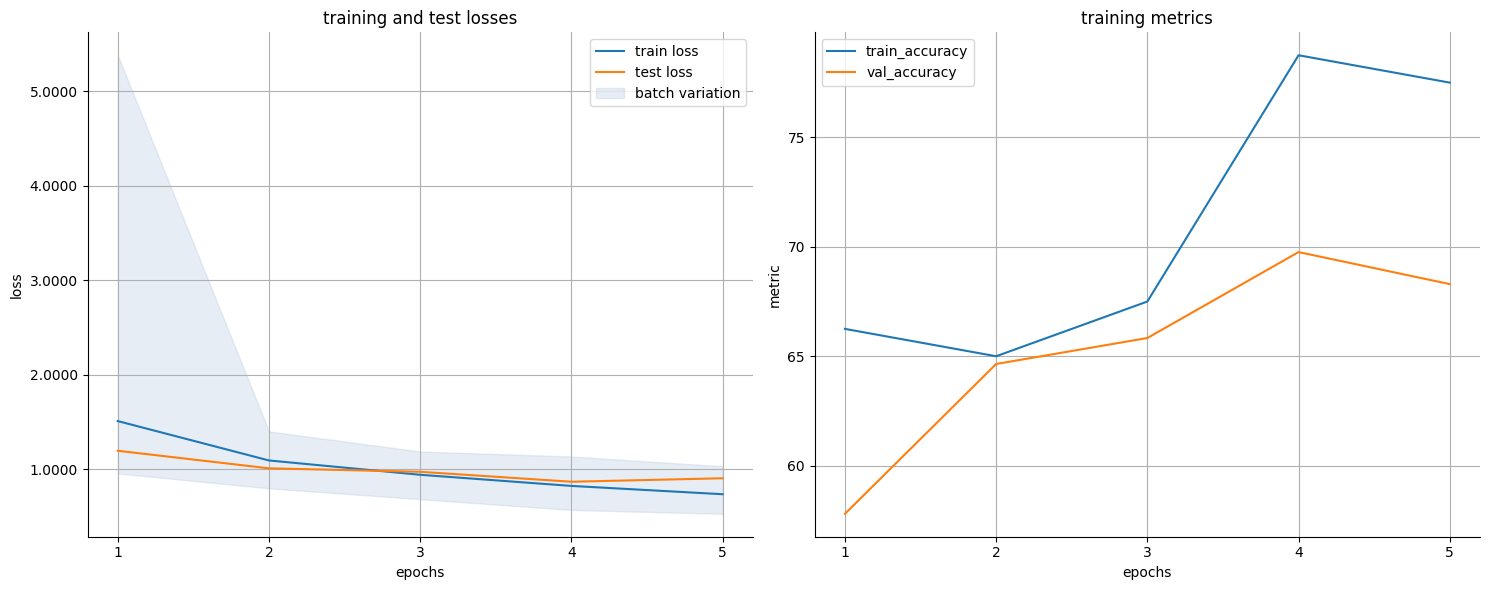


📈 Analyzing Prediction Dynamics
Left: Loss should decrease smoothly. Spikes indicate instability.
Right: Class predictions should stabilize over time. Excessive changes suggest learning issues.

Initial loss: 1.0485
Final loss: 0.7836
Loss reduction: 0.2649



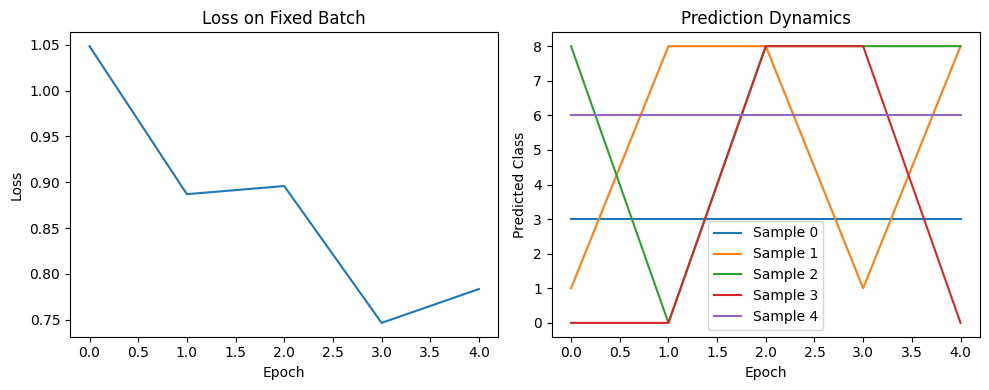

In [7]:
model0 = SimpleCNN()
trainer0 = train_model(model0, "SimpleCNN", num_epochs=5)

Random seed set to 42 for reproducibility.

🚀 Running Karpathy's Verification Tests
These tests help verify the training setup and catch common issues early.


🔍 Checking Initial Loss
Initial loss should be close to -log(1/n_classes) for random predictions.
Zero-input loss should be higher than normal input loss, showing the model uses input information.

Initial loss: 3.2301
Expected loss for random predictions: 2.3026
⚠️  Initial loss deviates by 40.3% from expected!
This might indicate improper weight initialization.
Zero input loss: 2.3026
❌ Loss difference is negative: -0.9275
Model performs worse on real data than zero input!
Suggestions:
1. Check weight initialization
2. Verify input normalization
3. Ensure model architecture is correct

👁️ Visualizing Network Input
Showing data exactly as it enters the model. Verify:
1. Images are properly normalized/preprocessed
2. Labels match the images
3. No unintended transformations

Data range: [-2.2425..2.4949]
Data mean: -0.1164, std: 

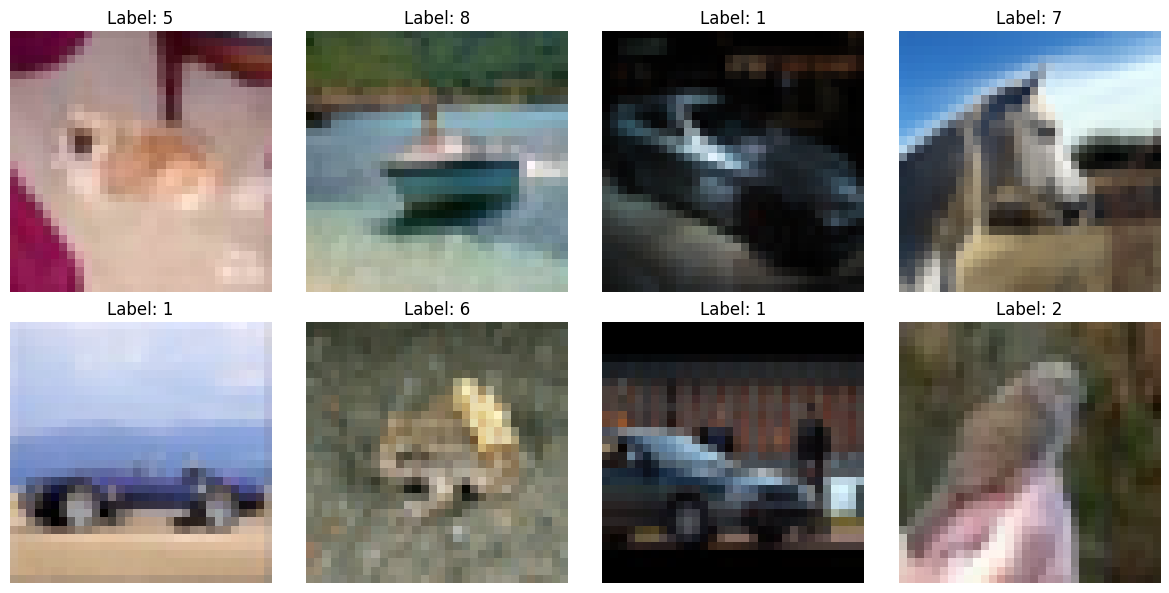


🎯 Testing Model Capacity
Attempting to overfit a single batch. Success indicates the model has sufficient capacity.
Target loss: 0.0100
Loss should decrease rapidly and reach near-zero.

Iteration 0: Loss = 3.424512
✅ Target loss reached at iteration 97

✅ Verification Tests Completed
Review the results above to ensure your training setup is solid.

Karpathy verification tests completed.
[epoch 01] train loss: 2.1205 | val loss: 1.9144 | accuracy: 37.16%
Validation loss decreased (inf --> 1.9144). Saving model.
[epoch 02] train loss: 1.8963 | val loss: 1.9273 | accuracy: 35.99%
EarlyStopping counter: 1 out of 5
[epoch 03] train loss: 1.8543 | val loss: 1.8706 | accuracy: 36.42%
Validation loss decreased (1.9144 --> 1.8706). Saving model.
[epoch 04] train loss: 1.8293 | val loss: 1.8995 | accuracy: 36.71%
EarlyStopping counter: 1 out of 5
[epoch 05] train loss: 1.8221 | val loss: 1.9088 | accuracy: 36.70%
EarlyStopping counter: 2 out of 5


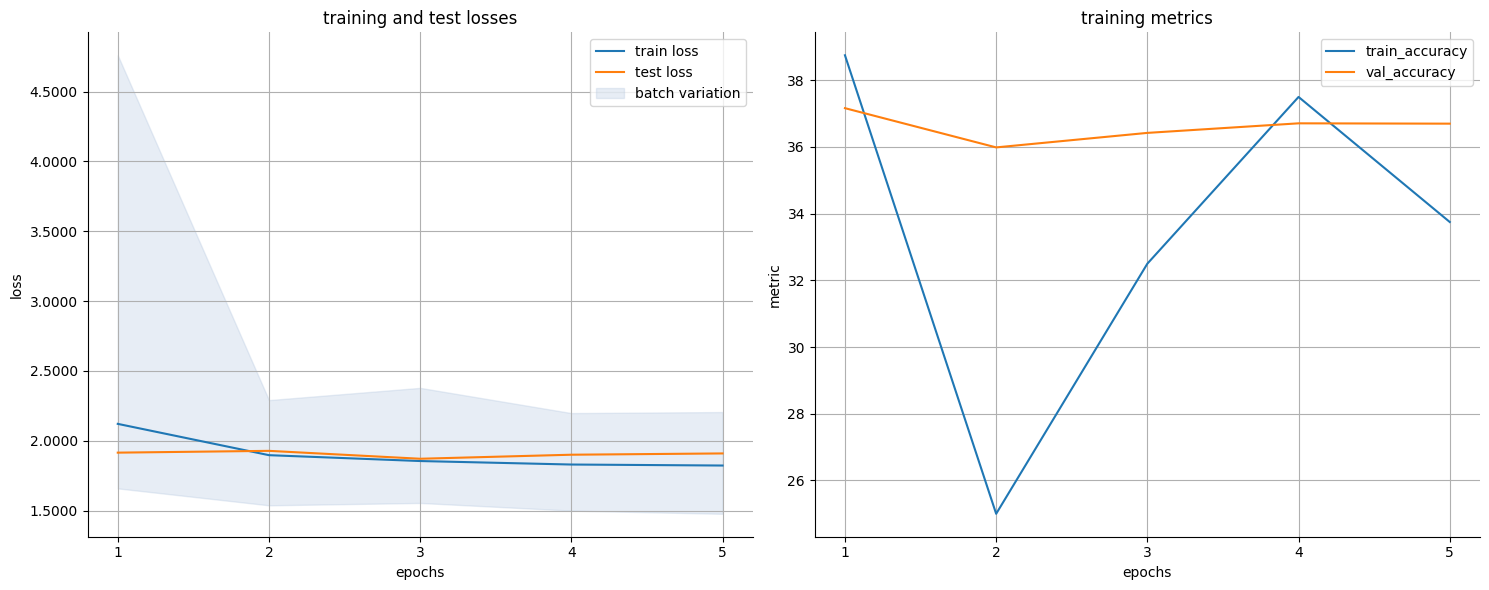


📈 Analyzing Prediction Dynamics
Left: Loss should decrease smoothly. Spikes indicate instability.
Right: Class predictions should stabilize over time. Excessive changes suggest learning issues.

Initial loss: 1.7809
Final loss: 1.8588
Loss reduction: -0.0779



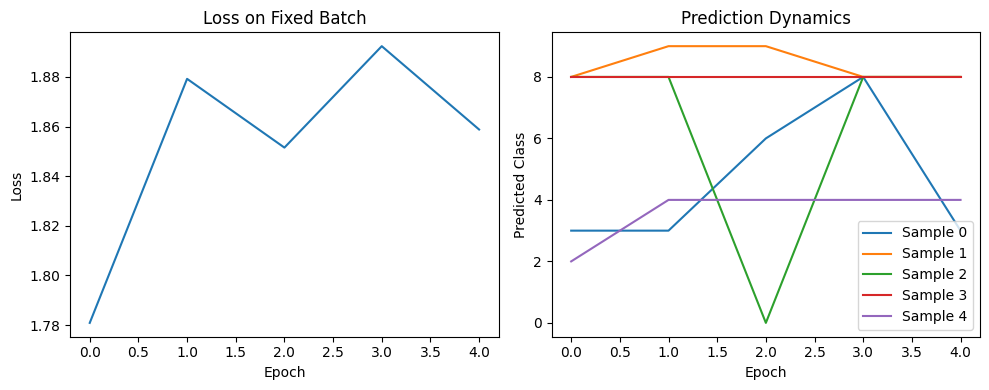

In [10]:
model1 = SuperSimpleNN(input_size=32*32*3, num_classes=10)
trainer1 = train_model(model1, "SuperSimpleNN", num_epochs=5)

## Step 5: Evaluate Models

In [ ]:
def evaluate_model(trainer, model_name):
    print(f"Evaluating {model_name}...")
    trainer.load_best_model()
    # assuming val_loader is the test set
    val_loss, metrics = trainer.evaluate(trainer.metrics_history['epochs'][-1], phase='val')
    print(f"{model_name} - Loss: {val_loss:.4f}, Metrics: {metrics}")

### Evaluate All Models

In [ ]:
evaluate_model(trainer1, "SimpleCNN")
evaluate_model(trainer2, "CNNWithBatchNorm")
evaluate_model(trainer3, "CNNWithDropout")

## Step 6: Plot Loss Curves

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(trainers, model_names):
    plt.figure(figsize=(10, 6))
    for trainer, name in zip(trainers, model_names):
        epochs = trainer.metrics_history['epochs']
        plt.plot(epochs, trainer.metrics_history['train_loss'], label=f"{name} Train Loss")
        plt.plot(epochs, trainer.metrics_history['val_loss'], label=f"{name} Val Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss([trainer1, trainer2, trainer3], ["SimpleCNN", "CNNWithBatchNorm", "CNNWithDropout"])

## Step 7: Analyze Per-Class Performance

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def per_class_analysis(trainer, model_name):
    trainer.load_best_model()
    trainer.model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in trainer.val_loader:
            data, targets = data.to(trainer.device), targets.to(trainer.device)
            outputs = trainer.model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    cm = confusion_matrix(all_targets, all_preds)
    classes = trainset.classes
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(all_targets, all_preds, target_names=classes))



### Analyze All Models

## Conclusion